# Resample a TEMP aggregated-timeseries by hour

This notebook show you how to resample an aggregated-timeseries by the hour. From a single netCDf aggregated file in indexed ragged array format, we will split the file by instrument, resample and then bind the resampled series again. Xarray and pandas have both a powerful resampling function but it is intended to resample by any of the dimensions of the file. As the aggregated-timeseries does not have TIME as a dimension, the resampling cannot be done automatically by any of those functions.


In [72]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm



In this case the file is accessed from AODN THREDDS server

In [2]:
fname = 'http://thredds.aodn.org.au/thredds/dodsC/IMOS/ANMN/QLD/PIL050/aggregated_timeseries/IMOS_ANMN-QLD_TZ_20120221_PIL050_FV01_TEMP-aggregated-timeseries_END-20140816_C-20190819.nc'
nc = xr.open_dataset(fname)

Look at the structure of the file

In [3]:
nc

<xarray.Dataset>
Dimensions:                   (INSTRUMENT: 16, OBSERVATION: 2781876)
Coordinates:
    TIME                      (OBSERVATION) datetime64[ns] ...
    LONGITUDE                 (INSTRUMENT) float32 ...
    LATITUDE                  (INSTRUMENT) float32 ...
    NOMINAL_DEPTH             (INSTRUMENT) float32 ...
Dimensions without coordinates: INSTRUMENT, OBSERVATION
Data variables:
    TEMP                      (OBSERVATION) float32 ...
    TEMP_quality_control      (OBSERVATION) float32 ...
    DEPTH                     (OBSERVATION) float32 ...
    DEPTH_quality_control     (OBSERVATION) int8 ...
    PRES                      (OBSERVATION) float32 ...
    PRES_quality_control      (OBSERVATION) float32 ...
    PRES_REL                  (OBSERVATION) float32 ...
    PRES_REL_quality_control  (OBSERVATION) float32 ...
    instrument_index          (OBSERVATION) int32 ...
    instrument_id             (INSTRUMENT) |S64 ...
    source_file               (INSTRUMENT) |S64 ..

We will split the dataset into small ones corresponding to each one of the INSTRUMENTS. The resampling will be done in a pandas dataframe as it is is easy with that to assign `TIME` as an index of the DF. The aggregated resampled data frame could be saved again as a netCDF file using the correct dimensions for the ragged array structure (`OBSERVATION` and    `INSTRUMENT`)

In [6]:
## get the number of instruments
nInstruments = int(nc.INSTRUMENT.max())
nInstruments

15

As an example we can plot the TEMP data from the first instrument. It is important to set the data frame index to `TIME` as it will be the dimension for the resampling. In this case I will take the average of all variables in the data resampled at one hour interval. I've also use the base / loffset combination to specify that I want 30 minutes before and 30 minute after the hour for the 1 hour bin. See [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html) and [here](https://stackoverflow.com/questions/56660797/how-do-i-resample-a-pandas-series-using-values-around-the-hour) for an explanation on how to use it.

In [115]:
## select the instrument
nc_tmp = nc.where(nc.instrument_index==1, drop=True)
## convert to dataframe
df = nc_tmp.to_dataframe()

print(nomdepth)
## set TIME as the index o fthe DF
df.set_index('TIME', inplace=True)
## do the magic! All the variables in the dataset will be averaged to one hour. we can use median() as well
df_1h = df.resample('60min',base=30,loffset='30min').mean()
df_1h.head()

[17.  23.  24.8 25.  28.  28.5 29.5 33.  42.5 45.  46.5 47.  49.  49.8
 51.  54. ]
[25.         42.5        17.         45.         46.5        28.5
 23.         49.         54.         28.         51.         33.
 49.79999924 29.5        24.79999924 47.        ]


,TEMP,TEMP_quality_control,DEPTH,DEPTH_quality_control,PRES,PRES_quality_control,PRES_REL,PRES_REL_quality_control,instrument_index,LONGITUDE,LATITUDE,NOMINAL_DEPTH
TIME,,,,,,,,,,,,
2012-02-21 04:00:00,28.003334,1.0,44.481716,1.0,NaN,9.0,44.759998,1.0,1.0,116.416016,-20.054613,37.099998
2012-02-21 05:00:00,27.841667,1.0,44.134426,1.0,NaN,9.0,44.410500,1.0,1.0,116.416016,-20.054613,37.099998
2012-02-21 06:00:00,27.788334,1.0,43.605957,1.0,NaN,9.0,43.878666,1.0,1.0,116.416016,-20.054613,37.099998
2012-02-21 07:00:00,27.861666,1.0,43.114746,1.0,NaN,9.0,43.384335,1.0,1.0,116.416016,-20.054613,37.099998
2012-02-21 08:00:00,27.886665,1.0,42.760830,1.0,NaN,9.0,43.028168,1.0,1.0,116.416016,-20.054613,37.099998


and the corresponding plot

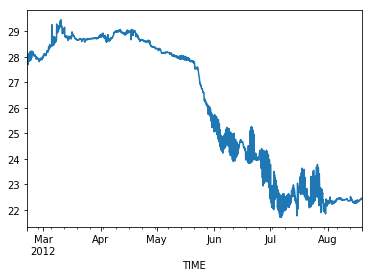

In [56]:
df_1h['TEMP'].plot()

Now, we can do all the instruments in a loop and plot the resulting hourly series colored by instrument

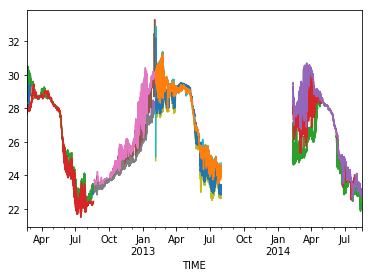

In [117]:
## define an empty data frame to store the resampled values
DF = pd.DataFrame()
## main loop
for instrument in range(nInstruments):
    nc_tmp = nc.where(nc.instrument_index==instrument, drop=True)
    df = nc_tmp.to_dataframe()
    df.set_index('TIME', inplace=True)
    df_1h = df.resample('60min',base=30,loffset='30min').mean()
    ## append to the resampled dataset
    DF = DF.append(df_1h)
    
    df_1h['TEMP'].plot()



In [62]:
DF.head()

,TEMP,TEMP_quality_control,DEPTH,DEPTH_quality_control,PRES,PRES_quality_control,PRES_REL,PRES_REL_quality_control,instrument_index,LONGITUDE,LATITUDE,NOMINAL_DEPTH
TIME,,,,,,,,,,,,
2012-02-21 04:00:00,30.108170,1.0,26.072968,1.0,NaN,9.0,NaN,9.0,0.0,116.416016,-20.054613,37.099998
2012-02-21 05:00:00,30.152626,1.0,25.743107,1.0,NaN,9.0,NaN,9.0,0.0,116.416016,-20.054613,37.099998
2012-02-21 06:00:00,30.129963,1.0,25.219582,1.0,NaN,9.0,NaN,9.0,0.0,116.416016,-20.054613,37.099998
2012-02-21 07:00:00,30.061371,1.0,24.714203,1.0,NaN,9.0,NaN,9.0,0.0,116.416016,-20.054613,37.099998
2012-02-21 08:00:00,29.937649,1.0,24.390574,1.0,NaN,9.0,NaN,9.0,0.0,116.416016,-20.054613,37.099998


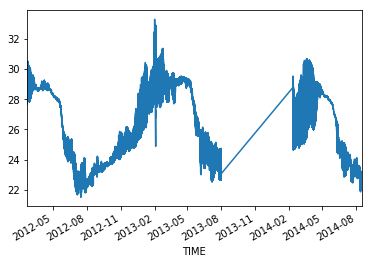

In [109]:
DF['TEMP'].plot(kind='line')